# Graded Lab Assignment 2: Evaluate classifiers (10 points)
 
In this assignment you will optimize and compare the perfomance of a parametric (logistic regression) and non-parametric (k-nearest neighbours) classifier on the MNIST dataset.

# Implementation of the experiment
### Import Modules

In [21]:
% pylab inline

from sklearn.datasets import load_digits # Dataset
from sklearn.preprocessing import StandardScaler # Data Pre-processing
from sklearn.neighbors import KNeighborsClassifier # K-NN Classifier
from sklearn.linear_model import LogisticRegression # Logistic Regression Classifier
from sklearn.model_selection import KFold, cross_val_score # Cross-Validation Functions
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # Analysis Functions
import itertools # Iteration Tools for Confusion Matrix

Populating the interactive namespace from numpy and matplotlib


### Load Dataset

In [24]:
digits = load_digits()

# training set
X_train_mnist = reshape(digits.images[:1500], (1500, 64))
y_train_mnist = digits.target[:1500]

# test set
X_test_mnist = reshape(digits.images[1500:], (297, 64))
y_test_mnist = digits.target[1500:]

### Data Pre-processing

In the case of this dataset, the only pre-processing method that seemed necessary to me after reviewing most of them was scaling the data. When I did not do this, the optimized values for `C` and `k` would always return to `1`. This was resolved after scaling the data to a standard distribution.

In [34]:
# standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

X_train_mnist = scaler.fit_transform(X_train_mnist)
X_test_mnist = scaler.transform(X_test_mnist)

### Default Parameters

For the default values of C and k I went for the values that are default according to the [sk-learn documentation](http://scikit-learn.org/stable/index.html), which was `C` = `1.0` and `k` = `5`.

In [33]:
# default regularization parameter
C = 1.0

# default number of neighbours
k = 5

# default cross-validation type
cv_type = KFold(n_splits = 10)

### Training (Using Default Parameters)

In [35]:
def train_classifier(classifier):
    """
    fits given classifier with the training data
    """
    global X_train_mnist, y_train_mnist
    classifier.fit(X_train_mnist, y_train_mnist)
    return classifier

# train logistic regression
def_lr_classifier = train_classifier(LogisticRegression(C = C))

# train k-nn
def_knn_classifier = train_classifier(KNeighborsClassifier(n_neighbors = k))

### Cross-validation

When running the optimization code I chose to only test out the odd values for `k`. This is so that there's never a case where there's an equal number of neighbours of the same class, and thus this prevents clashes. For `C` I chose the values `0.1`-`1.0`, since taking a lot more values in between would take an incredibly long amount of time to compute.

In [36]:
def cross_validate(classifier, values):
    """
    picks value with best cv-score out of a range of values
    returns a tuple containing the optima for value and score and the overall values and scores
    """
    global cv_type
    opt_score = 0
    opt_val = 0
    all_scores = []
    
    for val in values:
        cv_classifier = classifier(val)

        # calculate average cv-score
        scores = cross_val_score(cv_classifier, X_train_mnist, y_train_mnist, cv=cv_type)
        score = scores.mean()
        all_scores.append(score)
        
        # update optimal score and value if it's higher
        if score > opt_score:
            opt_score = score
            opt_val = val
    
    #return optimal value and cv-score
    return (opt_val, opt_score, values, all_scores)


# -- optimize regularization parameter C

# C values from 0.1 to 1.0
C_vals = np.array(range(1, 11)) / 10

# calculate C with best cv-score
print("Calculating optimal C...")
(opt_C, lr_opt_score, C_vals, C_cv_scores) = cross_validate(lambda C: LogisticRegression(C = C), C_vals)

print("Optimal regularization parameter C =", opt_C, ", cv-score:", lr_opt_score)

# -- optimize no. of neighbours k

# use only odd k's in order to avoid clashes
odd_ks = [k for k in range(1,30) if k % 2 != 0]

# calculate k with best cv-score
print("Calculating optimal k...")
(opt_k, knn_opt_score, k_vals, k_cv_scores) = cross_validate(lambda k: KNeighborsClassifier(n_neighbors = k), odd_ks)

print("Optimal no. neighbors k =", opt_k, ", cv-score:", knn_opt_score)

Calculating optimal C...
Optimal regularization parameter C = 0.9 , cv-score: 0.954
Calculating optimal k...
Optimal no. neighbors k = 5 , cv-score: 0.962666666667


### Training (Using Optimized parameters)

In [37]:
# train logistic regression
opt_lr_classifier = train_classifier(LogisticRegression(C = opt_C))

# train k-nn
opt_knn_classifier = train_classifier(KNeighborsClassifier(n_neighbors = opt_k))

# Results and analysis of the experiment
### Cross-Validation Performance

As you can see in the graphs down below, both classifiers have relatively high accuracy scores when fully optimized. However, the values do not differ too much from their initial (default) scores, since they were already pretty close to their optimal values. This method would still be useful though in the case where you would have a default C or k that is not that close to these values.

Cross-validation Accuracy Scores:

Default Logistic Regression: 0.953333333333
Default K-Nearest Neighbours: 0.962666666667
Optimized Logistic Regression: 0.954
Optimized K-Nearest Neighbours: 0.962666666667


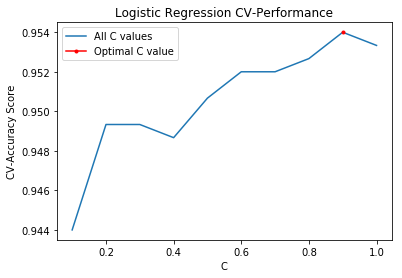

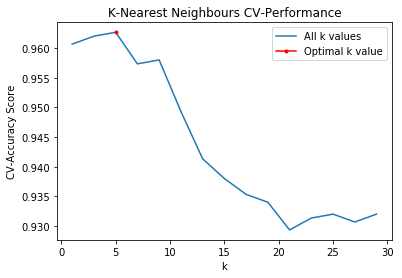

In [38]:
# calculate default cv-scores
def_lr_cv_score = cross_val_score(def_lr_classifier, X_train_mnist, y_train_mnist, cv=cv_type).mean()
def_knn_cv_score = cross_val_score(def_knn_classifier, X_train_mnist, y_train_mnist, cv=cv_type).mean()

# calculate optimized cv-scores
opt_lr_cv_score = cross_val_score(opt_lr_classifier, X_train_mnist, y_train_mnist, cv=cv_type).mean()
opt_knn_cv_score = cross_val_score(opt_knn_classifier, X_train_mnist, y_train_mnist, cv=cv_type).mean()

print("Cross-validation Accuracy Scores:\n")
print("Default Logistic Regression:", def_lr_cv_score)
print("Default K-Nearest Neighbours:", def_knn_cv_score)
print("Optimized Logistic Regression:", opt_lr_cv_score)
print("Optimized K-Nearest Neighbours:", opt_knn_cv_score)

def plot_cv_result(xlab, opt_val, opt_score, values, all_scores, title_n):
    """
    plots a graph visualizing the different CV-accuracy scores for a
    given set of values
    """
    plot(values, all_scores, label="All "+xlab+" values")
    plot([opt_val], [opt_score], marker='o', markersize=3, color="red", label="Optimal "+xlab+" value")
    title(title_n)
    xlabel(xlab)
    ylabel("CV-Accuracy Score")
    legend()
    show()

# plot the average cross validation accuracies for different values of the parameter 

plot_cv_result("C", opt_C, lr_opt_score, C_vals, C_cv_scores, "Logistic Regression CV-Performance")
plot_cv_result("k", opt_k, knn_opt_score, k_vals, k_cv_scores, "K-Nearest Neighbours CV-Performance")

### Test Performance

When taking a look at the test performance of both classifiers, you can see that in general the K-Nearest Neighbours classifier performs slightly better than the Logistic Regression classifier. However, Logistic Regression does perform better in classifying label 2, where it has a better precision, recall and f1-score than K-NN. Logistic Regression also has better precision and f1-score on label 5, but its recall is equal to K-NN's (`1.0`).

In [39]:
def print_report(classifier, title):
    """
    prints classification report for the given classifier
    """
    global y_test_mnist, X_test_mnist
    print(title+":\n")
    print(classification_report(y_test_mnist, classifier.predict(X_test_mnist)))

print_report(opt_lr_classifier, "Logistic Regression")
print_report(opt_knn_classifier, "K-Nearest Neighbours")

Logistic Regression:

             precision    recall  f1-score   support

          0       0.96      0.93      0.94        27
          1       0.82      0.90      0.86        31
          2       1.00      1.00      1.00        27
          3       0.90      0.60      0.72        30
          4       0.94      0.91      0.92        33
          5       0.91      1.00      0.95        30
          6       0.94      1.00      0.97        30
          7       0.87      0.87      0.87        30
          8       0.70      0.93      0.80        28
          9       0.92      0.77      0.84        31

avg / total       0.90      0.89      0.89       297

K-Nearest Neighbours:

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        27
          1       0.89      1.00      0.94        31
          2       0.96      0.93      0.94        27
          3       0.96      0.80      0.87        30
          4       1.00      0.88      0.94        

### Confusion Matrices

When you look at both confusion matrices you see that either classifier has relatively little issues with misclassification. The few misclassifications that they do make though, are roughly the same (take for example label 8 that's misclassified as 1 in both classifiers and label 3 that seems to be the most misclassified in both classifiers). This can probably be explained by these labels being similar or closely related to each other. Logistic Regression also seems to have a more spread out range of misclassifications whereas those of K-Nearest Neighbours are more concentrated in single class pairs.

**Note:** `plot_confusion_matrix` function was made with help of the scikit-learn [tutorial](http://www.bitly.com/sklearncm) on confusion matrices

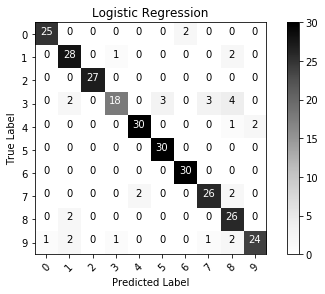

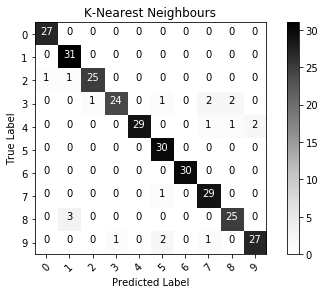

In [40]:
def plot_confusion_matrix(classifier, title):
    """
    generates a confusion matrix for the given classifier
    and the test set and visually renders a table with the
    amount of predicted classes for each class.
    """
    global y_test_mnist, X_test_mnist, digits
    
    plt.figure()
    
    cm = confusion_matrix(y_test_mnist, classifier.predict(X_test_mnist))
    classes = digits.target_names
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greys)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# plot confusion matrices
plot_confusion_matrix(opt_lr_classifier, "Logistic Regression")
plot_confusion_matrix(opt_knn_classifier, "K-Nearest Neighbours")

In [42]:
import antigravity